# Toxic comments - Iteration # 5

### Date: 11th Dec 2020
Sherry

The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

#### Changes made to feature building and extraction:
  1. **added bigrams and custom stopwords**
  
        `hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2), stop_words = new_stop_words)`
        
        
  2. **added smooth_idf parameter as False**
  
        `TfidfTransformer(smooth_idf=False)`
        
        
  3. **Added two features: question counts and exclamation counts**
            `toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")`
            `toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")`
       

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        
    #custom stopwords Kavita Ganesan from https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt     
    new_stop_words = open('stopwords.txt','r').read().split('\n')

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 13, alternate_sign=False, strip_accents = 'ascii', ngram_range=(3,5), stop_words='english', analyzer = 'word')
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2), stop_words = new_stop_words)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer(smooth_idf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")

    
#     toxic_data['allcaps_count'] = toxic_data['comment_text'].str.findall(r'[A-Z]').str.len()

#     X_quant_features = toxic_data[["word_count", "exclaim_count", "allcaps_count"]]
    X_quant_features = toxic_data[["word_count", "exclaim_count", "quest_count"]]
#     X_quant_features = toxic_data[["word_count", "exclaim_count"]]


    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.0000001, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../../data/toxiccomments_train.csv', my_random_seed=1999)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Shape of HashingVectorizer X:
(159571, 131072)
Look at a few rows of the new quantitative features: 
   word_count  exclaim_count  quest_count
0          42              0            1
1          18              1            0
2          42              0            0
3         112              0            0
4          13              0            1
5          12              0            0
6           8              0            0
7          21              0            0
8          83              0            1
9          12              0            0
Size of combined bag of words and new quantitative variables matrix:
(159571, 131075)
(159571, 131075)
Shape of X_train and X_test:
(159570, 131075)
(1, 131075)
Shape of y_train and y_test:
(159570,)
(1,)
Shape of X_raw_train and X_raw_test:
(159570, 12)
(1, 12)
SUCCESS!
Number of fits stored in `fitted_transformations` list: 
3


# Fit (and tune) Various Models

### MODEL: Naive Bayes

In [5]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=0.01)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 15794, 'TN': 135442, 'FP': 7903, 'FN': 431, 'Accuracy': 0.9477721376198533, 'Precision': 0.6664978689285563, 'Recall': 0.9734360554699538, 'desc': 'nbs_train'}


In [6]:
from sklearn.naive_bayes import ComplementNB
nb_c = ComplementNB(alpha=580, norm=True)
nb_c.fit(X_train, y_train)

nb_c_performance_train = BinaryClassificationPerformance(nb_c.predict(X_train), y_train, 'nb_c_train')
nb_c_performance_train.compute_measures()
print(nb_c_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 15145, 'TN': 134150, 'FP': 9195, 'FN': 1080, 'Accuracy': 0.9356081970295168, 'Precision': 0.6222267871815941, 'Recall': 0.9334360554699538, 'desc': 'nb_c_train'}


### MODEL: SVM-C

In [7]:
from sklearn.svm import LinearSVC
svmc_0002 = LinearSVC(loss='squared_hinge', C=0.0002)
svmc_0002.fit(X_train, y_train)

svmc_0002_performance_train = BinaryClassificationPerformance(svmc_0002.predict(X_train), y_train, 'svmc_0002_train')
svmc_0002_performance_train.compute_measures()
print(svmc_0002_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 16194, 'TN': 143325, 'FP': 20, 'FN': 31, 'Accuracy': 0.9996803910509494, 'Precision': 0.998766498088072, 'Recall': 0.9980893682588597, 'desc': 'svmc_0002_train'}


### MODEL: Ridge Regression Classifier

#### Changes made to ridge regression classifier:

  1. **change alphas to 800, 50, 30, 20, 25, 35, 50000**
  
          
  2. **added normalization parameter and changed the solver to the SAG methodology**
  
        `normalize=True, solver='sag'`
        
        This doesn't work on higher alphas though - error of scalars
        
       

#### MODEL: Ridge Regression Classifier (alpha = 800)

In [8]:
from sklearn import linear_model


rdg_800 = linear_model.RidgeClassifier(alpha = 800, normalize=True, solver='sag')
rdg_800.fit(X_train, y_train)

rdg_800_performance_train = BinaryClassificationPerformance(rdg_800.predict(X_train), y_train, 'rdg_800_train')
rdg_800_performance_train.compute_measures()
print(rdg_800_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 12873, 'TN': 142409, 'FP': 936, 'FN': 3352, 'Accuracy': 0.9731277809111989, 'Precision': 0.9322181186182924, 'Recall': 0.7934052388289676, 'desc': 'rdg_800_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50)

In [9]:
rdg_50 = linear_model.RidgeClassifier(alpha = 50, normalize=True, solver='sag')
rdg_50.fit(X_train, y_train)

rdg_50_performance_train = BinaryClassificationPerformance(rdg_50.predict(X_train), y_train, 'rdg_50_train')
rdg_50_performance_train.compute_measures()
print(rdg_50_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15774, 'TN': 134026, 'FP': 9319, 'FN': 451, 'Accuracy': 0.9387729523093313, 'Precision': 0.6286215279161519, 'Recall': 0.9722033898305085, 'desc': 'rdg_50_train'}


#### MODEL: Ridge Regression Classifier (alpha = 30)

In [10]:
from sklearn import linear_model
rdg_30 = linear_model.RidgeClassifier(alpha = 30, normalize=True, solver='sag')
rdg_30.fit(X_train, y_train)

rdg_30_performance_train = BinaryClassificationPerformance(rdg_30.predict(X_train), y_train, 'rdg_30_train')
rdg_30_performance_train.compute_measures()
print(rdg_30_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15913, 'TN': 132569, 'FP': 10776, 'FN': 312, 'Accuracy': 0.9305132543711224, 'Precision': 0.5962381505489153, 'Recall': 0.9807704160246533, 'desc': 'rdg_30_train'}


#### MODEL: Ridge Regression Classifier (alpha = 20)

In [11]:
from sklearn import linear_model
rdg_20 = linear_model.RidgeClassifier(alpha = 20, normalize=True, solver='sag')
rdg_20.fit(X_train, y_train)

rdg_20_performance_train = BinaryClassificationPerformance(rdg_20.predict(X_train), y_train, 'rdg_20_train')
rdg_20_performance_train.compute_measures()
print(rdg_20_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 16016, 'TN': 131295, 'FP': 12050, 'FN': 209, 'Accuracy': 0.9231747822272357, 'Precision': 0.570654884914131, 'Recall': 0.9871186440677966, 'desc': 'rdg_20_train'}


#### MODEL: Ridge Regression Classifier (alpha = 25)

In [12]:
from sklearn import linear_model
rdg_25 = linear_model.RidgeClassifier(alpha = 25, normalize=True, solver='sag')
rdg_25.fit(X_train, y_train)

rdg_25_performance_train = BinaryClassificationPerformance(rdg_25.predict(X_train), y_train, 'rdg_25_train')
rdg_25_performance_train.compute_measures()
print(rdg_25_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15961, 'TN': 132004, 'FP': 11341, 'FN': 264, 'Accuracy': 0.927273296985649, 'Precision': 0.5846091861402095, 'Recall': 0.9837288135593221, 'desc': 'rdg_25_train'}


#### MODEL: Ridge Regression Classifier (alpha = 35)

In [13]:
from sklearn import linear_model
rdg_35 = linear_model.RidgeClassifier(alpha = 35, normalize=True, solver='sag')
rdg_35.fit(X_train, y_train)

rdg_35_performance_train = BinaryClassificationPerformance(rdg_35.predict(X_train), y_train, 'rdg_35_train')
rdg_35_performance_train.compute_measures()
print(rdg_35_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15881, 'TN': 133038, 'FP': 10307, 'FN': 344, 'Accuracy': 0.9332518643855361, 'Precision': 0.6064227890636933, 'Recall': 0.9787981510015409, 'desc': 'rdg_35_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50000)

In [14]:
from sklearn import linear_model
rdg_50000 = linear_model.RidgeClassifier(alpha = 50000)
rdg_50000.fit(X_train, y_train)

rdg_50000_performance_train = BinaryClassificationPerformance(rdg_50000.predict(X_train), y_train, 'rdg_50000_train')
rdg_50000_performance_train.compute_measures()
print(rdg_50000_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 15723, 'TN': 143309, 'FP': 36, 'FN': 502, 'Accuracy': 0.9966284389296234, 'Precision': 0.9977155910908052, 'Recall': 0.969060092449923, 'desc': 'rdg_50000_train'}


### ROC plot to compare performance of various models and fits

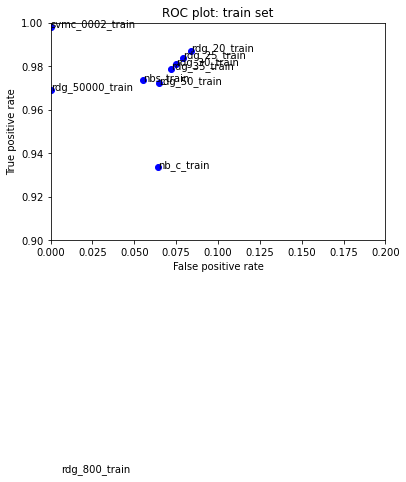

In [15]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_50_performance_train, svmc_0002_performance_train, rdg_800_performance_train, rdg_50000_performance_train]
fits = [svmc_0002_performance_train, nbs_performance_train, nb_c_performance_train, rdg_50_performance_train,rdg_30_performance_train,rdg_20_performance_train, rdg_25_performance_train, rdg_35_performance_train, rdg_800_performance_train, rdg_50000_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.2, 0.9, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [16]:
rdg_predictions = rdg_25.predict(X_train)

In [17]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
99
"
 Got it! Replying now -  ❤ "
* * * * * * * * * 
551
Your Warning 
You warned me for a revert that was justified, i had reverted vandalism. Please check more carefully next time before reverting my revert.
* * * * * * * * * 
675
you were nice to start with?  rofl.. no wonder you can't get laid. 

don't bother me.. don't mess with my edits.. and i won't bother you from my dynamic ip

one more edit or comment and i will bookmark your user page.

if you want to ask what the experience is like ask angelofsadness

go find a girlfriend.
* * * * * * * * * 
756
Yes but conspiring to kill somebody over a drawing of Mohammud IS Islamist!
* * * * * * * * * 
883
References indicated. Would you also like to see a photo of my Emmy Award sitting nearby or copies of my books? Stop acting like a pompous Luddite.
* * * * * * * * * 
1089
Thank you ==
yes thanks for not making that I.P ban on my old user, but not for blocking my account, that was not nice (.   

==
* * * *

17779
new article name 

this should be renamed have i got news for you episode guide, thats what this is and thats what these things are usually called (well on tv.com and most of the links in google) the current name is too long and sounds childish, and i dont know why its the same for the simpsons and family guy, seems ridiculous nobody thought of episode guide as a more convenient search
* * * * * * * * * 
18071
" ps: I have to admit that ""childish"" and ""unbearable"" are the wrong words which I hereby would like to withdraw."
* * * * * * * * * 
18427
You're not an a illeterate.  You're an illiterate.
* * * * * * * * * 
18552
oh why dear johnny boy part one (again again) 

just reply for once
* * * * * * * * * 
19124
Jon is so smart.  S M R T!  Smart, smart, smart!
* * * * * * * * * 
19195
Message for Bar 

Are you sure that I am blocked?

122.106.83.63   (767-249ER- Admin)
* * * * * * * * * 
19279
Would definitely work better with you 

Pugidsound
The Rat King
* * * * * * * * * 

33857
Apology 

Hey, I apologize for that little incident. Just ask me before warning me next time. Thanks! =D -
* * * * * * * * * 
33902
LOTHAR VON TROTHA
GOOD RIDDANCE TO HIM, HE KILLED SO MANY INNOCENT HERERO. HE DIED FROM TYPHOID FEVER IN PAIN, CAUGHT IT FROM POISONED FOOD, DRINK!!!
 mywikibiz.com/Lothar_von_Trotha
* * * * * * * * * 
34502
Awww, my deepest appologies, here's a Kleenex.
* * * * * * * * * 
34624
There is no power given to you that can make you better person. Its your shoice to be who you are. I dont like people like you. 76.114.213.50
* * * * * * * * * 
34883
Great Job! Exactly what i was looking for, I`ll go re-read it and check for other errors =D
* * * * * * * * * 
35088
People need to keep a better eye on this page. It's had repeated vandalism.
* * * * * * * * * 
35758
"
Right now, it is probably better to have it like we would have with ""Gurongi"", ""Imagin"", and ""Undead"". ""Yummies"" as it stands does not look like a good plural form, even if the plural of 

47173
WHAT!!!!!! 

I FIRMLY BELIEVE THAT SPANKING SHOULD BE OUT LAWED EVERYWHERE!!!!!!!
* * * * * * * * * 
47855
It is not just you. This is a laundry list of stupid allegations scooped up from god-knows-where. Probably two-thirds of it has little basis in fact.
* * * * * * * * * 
48130
Note one previous comment: To my knowledge of remembrence, Cage did not have a bloody nose in National Treasure. Correct me, if I am wrong, but I am fairly sure of that.
* * * * * * * * * 
48392
Annoying, isn't it? 

Maybe you won't hound other users edits in future...
* * * * * * * * * 
48651
i clearly think you should stop to 

you defending a mstement you do not know or threating and defending some kid for saying hee hates black people and hispanics i do not respect that
* * * * * * * * * 
48676
dont have right to revert it!
* * * * * * * * * 
48815
HAPPY BIRTHDAY  SIR CHOULES!!!
* * * * * * * * * 
49090
I didn't call you a Yank.  And I don't give a flying toss what absurd convention a handful of peo

74384
"
I like messing around with your talk page. Can I do it every day? — Nearly Headless Nick  {C} {L} "
* * * * * * * * * 
74390
Thıs ıs an outrıght and outrageous lıe.  There ıs no Byzantıne Flag wıth a crescent moon.  There never was and there never wıll be.  Ho wabout some responsıbılıty wıkıpedıa?  Do you now prınt lıes?
* * * * * * * * * 
75061
Is the photograph a still from a monster movie or really a banded cat- eyed snake?
* * * * * * * * * 
75180
I believe it because of that I live in central-Europe.
* * * * * * * * * 
75264
ok mister photographer, they are demolishing the electric furnace melt from both sides tomorrow, i'd go down to third street and take a stool so you can shoot over the fence unless you have wire clippers. a picture is worth a thousand words. your not going to shoot digital are you?
* * * * * * * * * 
75475
Then go ahead and block me!... It's really what I want!...
* * * * * * * * * 
75674
Stop this ochlarchical nonscence!!!!  

What you are doing is oc

90507
I dont have money to do a research of you, stay away
* * * * * * * * * 
90655
Release date 
Please dont edit the release date until Lion head or a reputable source confirms it.
* * * * * * * * * 
90951
"

 Barnstar 

  The Real Life Barnstar "
* * * * * * * * * 
91260
Jimmy B Watson 

What the hell is your problem?  Also, please divulge why you are so closely monitoring this matter with your petty-assed BS.  There is something seriously wrong with you and if you cannot come up with something actually valid, you'll be reported.  But maybe that doesn't matter, depending on whose pocket you're in. In any case, your role will become known far beyond this page.  I did not come here by accident to correct this abuse.
* * * * * * * * * 
91294
INPORTANT 

You Know What I Dont Have To Listen To You I Worked Hard And My Creative Skills Are GOOD !

ElvisPresley1
* * * * * * * * * 
91327
Angela the barn award winner 

You are about to be blocked for your obscene figure and editing and for yo

104024
Oohh. Obviously I was a retard.
* * * * * * * * * 
104082
Come to west bengal.  I shall show you what goes on in the muslim villages.
* * * * * * * * * 
104104
twinkie house 134.226.1.229   (momma so fa6t)
* * * * * * * * * 
104140
"

Please stop. If you continue to vandalise Wikipedia, as you did to Beavis and Butt-head, you will be banned from editing. ≈  "
* * * * * * * * * 
104690
you are a nice guy 

you are a nice guy
* * * * * * * * * 
104906
"

Bullying? Would threatening to commit a crime against the author constitute ""bullying""? As I've pointed out numerous times, Zarove threatened to publish Acharyas credit information online if I didn't back off. Procuring someones credit report under false pretenses is a crime. Furthermore, this suggests Zarove has Acharyas SSN. The mentally ill person who kidnapped her child is known to have passed Acharyas personal information, such as her SSN, to fringe religious groups like tektonics.org.  He is wanted by the authorities. Zaro

111350
Your behavier is a disgrace to wikipedia.
* * * * * * * * * 
111394
...and here's another: . Some people just don't give up, do they?
* * * * * * * * * 
111873
calm down

Seriously, man, you are beginning to scare me. What's with all the high drama and blustering? An ANI report? Why? What for? Perhaps you should take a healthy dose of WP:MASTADONS and consider taking a break. Seriously.
* * * * * * * * * 
112654
Vandalism 

can someone protect the page because there has been alot of edits and its really getting annoying when people do it to bother others.
* * * * * * * * * 
112737
Yes, you are certainly predisposed to support Sanchez, regardless of what's true. It is people like you who have made Wikipedia such a joke.
* * * * * * * * * 
112882
"
I'm sick to death of the ""I'm right and you're wrong"" mentality purveying Wikipedia lately. 204.69.190.254  "
* * * * * * * * * 
112975
So if i did nothing after his warning, what business does he have to say I didn't take it seriousl

125038
Big boy! Dreaming has never been so good. My dear, land on Earth. You live with the money from his father and lives in Belo Horizonte in an apartment in the Castle District.
* * * * * * * * * 
125147
Oh come on, this stuff is bottom-of-the-barrel grade crap.2.103.197.76
* * * * * * * * * 
126591
"
FYI, those mean the same thing. ""Has lost their pulse"" is colloquial language for ""Is in cardiac arrest"" –  | talk "
* * * * * * * * * 
126920
False Friends of the Slavist 

I recommend you talk with Miloš Rančić about this. He studies slavistic.
* * * * * * * * * 
126985
"
He did write a book about all this stuff, so its not like ""Bob"" was trying to hide the truth.  And his very public arrests AND cheating on his wife are kinda hard to hide, too.  No need to sugarcoat the dead - they don't care anymore.   "
* * * * * * * * * 
127314
My Friends 

go hit me babe!
* * * * * * * * * 
127332
"
It was not me who used the IPs, see below. As there is absolutely no basis for my block, ju

139272
lol dude you are one funny chick.
* * * * * * * * * 
139464
Ya dude thats not cool
* * * * * * * * * 
139635
Mattyboy786
Hello there. I would just like to tell you how people like me don't appreciate it when nerds like you mess up our time to have fun. Thank you.

Oh, and if you think that I always screw around, just check my edit on Bearded Dragons'Italic text'Italic text'Italic text'''''
* * * * * * * * * 
140071
YOURS TOO, MOLOBO! You can delete this sentence as much as you want!
* * * * * * * * * 
140187
I pray to God that you will get the best Man as your life partner. I really love you. 

 I envy all men who had the privilege of hugging you and getting your love.
* * * * * * * * * 
140232
What is going on? 
Very weird here right now. Is
* * * * * * * * * 
140706
Deletion, Respond! That is an order 

Captaim, ugly, why did you delete that page?
* * * * * * * * * 
140712
Unfortunately, I'm not paid for my WP activities (although some people suspect that some Russian users AR

153668
"

Nationalists websites ? There is a decision of Polish court only. Wikipedia ? There is a picture of Polish nationalists with Roman salute long before the war. YouTube ? The archival movie with Polish Falcon trainers who do Roman salute. If archival documents aren't variable source so what is ? Jewish organziations who call NOP ""neo-nazi"" when NOP is against Socialism ?..

  "
* * * * * * * * * 
153855
I am watching you.........post something or get eaten by a Jewish Nazi p
* * * * * * * * * 
153889
Hi Paula! 

Great job! Someone's gotta straighten all these naughty guys out. Heartening to see you putting all your soul into it! Good girl! ;0)  

 Hey! PAULA Darling! 

Listen, don't let deletions and silly accusations without any base whatsoever earn you the wrath of bloodthirsty Admins! Not in your interest! You oghta play it cleverly! Let them SEE what happened and judge accordingly. Canadian teenager girls tend to get the brunt of bad vipes here. You are no exception, even

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'nbs_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


In [19]:
nb_c_performance_test = BinaryClassificationPerformance(nb_c.predict(X_test), y_test, 'nbc_test')
nb_c_performance_test.compute_measures()
print(nb_c_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'nbc_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


In [20]:
svmc_0002_performance_test = BinaryClassificationPerformance(svmc_0002.predict(X_test), y_test, 'svm_test')
svmc_0002_performance_test.compute_measures()
print(svmc_0002_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'svm_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


In [21]:
rdg_20_performance_test = BinaryClassificationPerformance(rdg_20.predict(X_test), y_test, 'rdg_20_test')
rdg_20_performance_test.compute_measures()
print(rdg_20_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_20_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


<ipython-input-22-3daa7999c0fb>:10: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
<ipython-input-22-3daa7999c0fb>:12: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


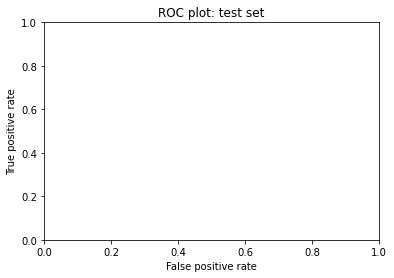

<ipython-input-22-3daa7999c0fb>:25: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
<ipython-input-22-3daa7999c0fb>:27: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


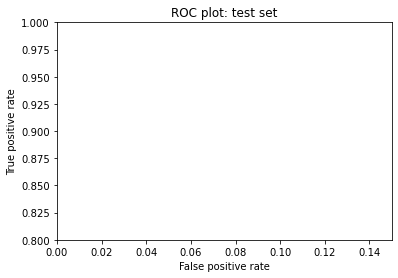

In [22]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_800_performance_test, rdg_50000_performance_test, rdg_50_performance_test, svmc_0002_performance_test]
fits = [nb_c_performance_test, svmc_0002_performance_test, nbs_performance_test, rdg_20_performance_test]


for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# fits_small = [svm_performance_test, rdg_50_performance_test, rdg_30_performance_test,rdg_20_performance_test, rdg_25_performance_test, rdg_35_performance_test, rdg_800_performance_test, svmc_0002_performance_test]
fits_small = [nb_c_performance_test, svmc_0002_performance_test, nbs_performance_test, rdg_20_performance_test]


for fit in fits_small:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.15, 0.8, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../../data/toxiccomments_test.csv', my_random_seed=1999, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  exclaim_count  quest_count
0          72              0            0
1          13              0            0
2          16              0            0
3          38              0            0
4           7     

### Prepare ensemble

In this iteration, I am choosing the **Ensemble VotingClassifier (Naive Bayes and Ridge )** model fit, which is in the `esb` object. 

In [24]:
from sklearn.ensemble import VotingClassifier
estimators = [('nb_c', nb_c), ('rdg', rdg_20)]
esb = VotingClassifier(estimators, voting='hard', weights =['1', '3'])
esb.fit(X_train, y_train)

esb_performance_train = BinaryClassificationPerformance(esb.predict(X_train), y_train, 'esb_train')
esb_performance_train.compute_measures()
print(esb_performance_train.performance_measures)


/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 16015, 'TN': 131291, 'FP': 12054, 'FN': 210, 'Accuracy': 0.9231434480165445, 'Precision': 0.570558267127436, 'Recall': 0.9870570107858243, 'desc': 'esb_train'}


---
I will now manually combine the predictions of `rdg`, `nb_c` and `svmc` to make the final predictions

In [25]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction_1"] = rdg_20.predict(X_test_submission)

# my_submission["prediction_2"] = nbs.predict(X_test_submission)

my_submission["prediction_3"] = nb_c.predict(X_test_submission)

my_submission["prediction_4"] = svmc_0002.predict(X_test_submission)

# my_submission["prediction_5"] = esb.predict(X_test_submission)

my_submission["prediction"] = my_submission[["prediction_1","prediction_3", "prediction_4"]].sum(axis=1) >= 1


In [31]:
# my_submission.head(40)
# store the id from the raw data
# my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# my_submission["prediction"] = esb.predict(X_test_submission)

# look at the proportion of positive predictions
print(my_submission['prediction'].mean())


0.362095531587057


In [27]:
my_submission = my_submission[['id', 'prediction']]

In [28]:
raw_data.head()

,id,comment_text,word_count,exclaim_count,quest_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,0,0


In [29]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,True
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [32]:
my_submission.shape

(153164, 2)

In [33]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('submission/toxiccomments_submission_iter_5.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation